# Welcome to ML Blog Tutorial 4 (Time Series Data)

This tutorial will present the application of four interpretability techniques in a machine learning task.

## Loading modules and libraries

In [ ]:
!pip install lime
!git clone https://github.com/intelligence-csd-auth-gr/LionLearn.git
!mv /content/LionLearn/LioNets_V2/lionets/datasets/ /content/datasets
!mv /content/LionLearn/LioNets_V2/lionets/utilities/ /content/utilities
!mv /content/LionLearn/LioNets_V2/lionets/lionets.py /content
!rm -r LionLearn

## Preparing time series data

We will use the [Turbofan Engine Degradation Simulation Dataset](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwjA7MPziIj4AhWOs6QKHQfsCNsQFnoECAkQAQ&url=https%3A%2F%2Fdata.nasa.gov%2Fdataset%2FTurbofan-engine-degradation-simulation-data-set%2Fvrks-gjie&usg=AOvVaw1Q0SyXovgztLFvT5_Fz_C1). The turbofan dataset features four datasets. The engines operate normally in the beginning but develop a fault over time. For the training sets, the engines are run to failure, while in the test sets the time series end ‘sometime’ before failure. The goal is to predict the Remaining Useful Life (RUL) of each turbofan engine. [Source](https://towardsdatascience.com/predictive-maintenance-of-turbofan-engines-ec54a083127)

In [ ]:
from utilities.load_dataset import Load_Dataset
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from collections import OrderedDict

fm, feature_names = Load_Dataset.load_data_turbofan(False)

fm1_train = fm['FaultMode1']['df_train']
fm1_train_target = fm1_train['RUL'].values
fm1_test= fm['FaultMode1']['df_test']
fm1_test_target = fm1_test['RUL'].values

We will drop a few uneccessary features and sensors

In [ ]:
drop_columns = ['t', 'os_1', 'os_2', 'os_3', 's_01', 's_02', 's_05', 
                's_06', 's_08', 's_10', 's_13', 's_15', 's_16', 's_18', 
                's_19', 's_22', 's_23', 's_24', 's_25', 's_26']
train = fm1_train.drop(columns=drop_columns)
test = fm1_test.drop(columns=drop_columns)

In [ ]:
train_units = set(train['u'].values)
test_units = set(test['u'].values)

We min max scale our data to 0.1,1 (and not to 0,1), as our data do not contain zero values. A zero value is tricky in explainability as it is considered neutral.

In [ ]:
sensors = ['s_03', 's_04', 's_07', 's_09', 's_11', 's_12', 's_14', 's_17', 's_20', 's_21']
scalers = {}
for column in sensors:
    scaler = MinMaxScaler(feature_range=(0.1,1))
    train[column] = scaler.fit_transform(train[column].values.reshape(-1,1))
    test[column] = scaler.transform(test[column].values.reshape(-1,1))
    scalers[column] = scaler

We split our data in instances with a time windnow of 20 time-steps.

In [ ]:
unit_scalers = {}
window = 20
temp_x_train = []
y_train = []
for unit in train_units:
    temp_unit = train[train['u']==unit].drop(columns=['u','RUL']).values
    temp_unit_RUL = train[train['u']==unit]['RUL'].values
    for i in range(len(temp_unit) - window + 1):
        temp_instance = []
        for j in range(window):
            temp_instance.append(temp_unit[i+j])
        temp_x_train.append(np.array(temp_instance))
        y_train.append(temp_unit_RUL[i+window-1])
y_train = np.array(y_train)
x_train = np.array(temp_x_train)

temp_x_test = []
y_test = []
for unit in test_units:
    temp_unit = test[test['u']==unit].drop(columns=['u','RUL']).values
    temp_unit_RUL = test[test['u']==unit]['RUL'].values
        
    for i in range(len(temp_unit) - window + 1):
        temp_instance = []
        for j in range(window):
            temp_instance.append(temp_unit[i+j])
        temp_x_test.append(np.array(temp_instance))
        y_test.append(temp_unit_RUL[i+window-1])
y_test = np.array(y_test)
x_test = np.array(temp_x_test)

We want to predict if the RUL value is above (0) or below (1) 30 time steps.

In [ ]:
time_frame = 30
y_train = np.array([1 if i <= time_frame else 0 for i in y_train])
y_test = np.array([1 if i <= time_frame else 0 for i in y_test])

## Inspecting an instance

Let's examine a random instance. We will plot the measurements for the selected sensors.

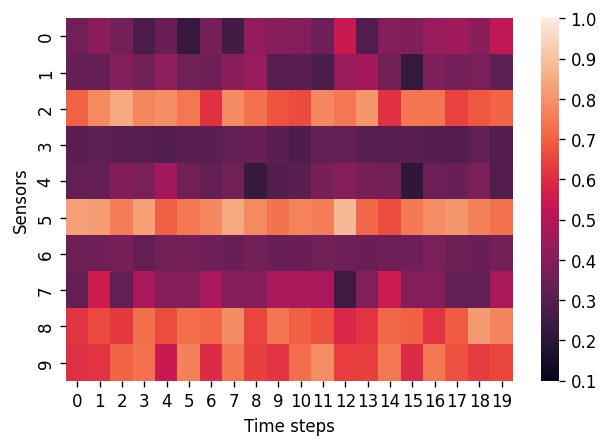

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(dpi=120)
ax = sns.heatmap(x_train[8475].T, vmin=0.1, vmax=1)
plt.xlabel('Time steps')
plt.ylabel('Sensors')
plt.show()

## Training the ML Model

Let's train a neural network to make predictions

In [ ]:
import keras
import keras.backend as K
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, TimeDistributed, RepeatVector,Flatten, Input, Dropout, LSTM, concatenate, Reshape, Conv1D, GlobalMaxPool1D
import tensorflow as tf

In [ ]:
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 
    
feature_names = fm1_train.columns
encoder_input = Input(shape=(x_train[0].shape))
encoded_input = Reshape((10,20))(encoder_input)
encoded_r = []
for i in range(10):
    temp_encoded = LSTM(units=20, dropout=0.5, return_sequences=True, activation='tanh')(encoded_input)
    temp_encoded = Dropout(0.7)(temp_encoded)
    temp_encoded = LSTM(units=20, dropout=0.5, return_sequences=False, activation='tanh')(temp_encoded)
    encoded_r.append(temp_encoded)
encoded = concatenate(encoded_r)
encoded = Dropout(0.7)(encoded)
encoded = Dense(200, activation='tanh')(encoded)#Relu and selu
encoded = Dropout(0.7)(encoded)
predictions = Dense(1, activation='sigmoid')(encoded)#Relu and selu
predictor = Model(encoder_input,predictions)
predictor.compile(optimizer="adam",loss=['binary_crossentropy'],metrics=['accuracy'])

checkpoint_name = 'TEDS_Predictor_Classification.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 2, save_best_only = True, mode ='auto')

In [ ]:
predictor.fit(x_train, y_train, epochs=10, batch_size=512, shuffle=True, 
              validation_split=0.3, verbose=2, callbacks=[checkpoint])

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, f1_score, balanced_accuracy_score, accuracy_score

weights_file = 'TEDS_Predictor_Classification.hdf5' # choose the best checkpoint few features
predictor.load_weights(weights_file) # load it
predictor.compile(optimizer="adam",loss=['binary_crossentropy'],metrics=['accuracy'])

temp_pred = predictor.predict(x_train)
predictions = [0 if i[0] <=0.5 else 1 for i in temp_pred]
print('Train:',f1_score(y_train,predictions, average='micro'),
      f1_score(y_train,predictions, average='weighted'),
      balanced_accuracy_score(y_train,predictions),
      accuracy_score(y_train,predictions))

temp_pred = predictor.predict(x_test)
predictions = [0 if i[0] <=0.5 else 1 for i in temp_pred]
print('Test:',f1_score(y_test,predictions, average='micro'),
      f1_score(y_test,predictions, average='weighted'),
      balanced_accuracy_score(y_test,predictions),
      accuracy_score(y_test,predictions))

Train: 0.9431423842827399 0.942522260653457 0.8865412816962157 0.9431423842827399
Test: 0.9816898892461593 0.9801643696129823 0.7701050889862839 0.9816898892461593


We will also need to build and train a decoder to use the LioNets technique

## Decoder
Building a decoder for LioNets

In [ ]:
encoder = Model(predictor.input, [predictor.layers[-2].output])
encoder.trainable = False
encoder.compile(optimizer="adam",loss=[root_mean_squared_error],metrics=['mae','mse'])

In [ ]:
encoded_x_train = encoder.predict(x_train)
encoded_x_test = encoder.predict(x_test)

In [ ]:
from keras.constraints import nonneg
encoded_input = Input(shape=(encoded_x_train[0].shape))
decoded_d = []
for i in range(10):
    temp = Dense(20, activation='linear')(encoded_input)
    temp = Reshape((20,1), input_shape=(20,))(temp)
    temp = LSTM(units=20, return_sequences=True, recurrent_activation='sigmoid', activation='relu')(temp)
    temp = LSTM(units=20, return_sequences=False, recurrent_activation='sigmoid', activation='relu', 
                kernel_constraint=nonneg())(temp)
    decoded_d.append(temp)
decoded = concatenate(decoded_d)
decoded = Reshape((20,10))(decoded)
decoder = Model(encoded_input,decoded)
decoder.compile(optimizer="adam", loss=root_mean_squared_error, metrics=['mse'])
checkpoint_name = 'TEDS_Decoder_Classification.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 2, save_best_only = True, mode ='auto')

In [ ]:
decoder.fit(encoded_x_train, x_train, epochs=150, batch_size=128, 
            shuffle=True, validation_split=0.2, verbose=2, callbacks=[checkpoint])

In [ ]:
weights_file = 'TEDS_Decoder_Classification.hdf5' # choose the best checkpoint few features
decoder.load_weights(weights_file) # load it
decoder.compile(optimizer="adam", loss=root_mean_squared_error, metrics=['mse'])

In [ ]:
decoder.evaluate(encoded_x_train,x_train)

586/586 [==============================] - 18s 22ms/step - loss: 0.0610 - mse: 0.0037


[0.06102757528424263, 0.00373009592294693]

In [ ]:
decoder.evaluate(encoded_x_test,x_test)

350/350 [==============================] - 8s 22ms/step - loss: 0.0611 - mse: 0.0037


[0.06113867089152336, 0.0037438622675836086]

## Interpretations!

We will use the same random instance as before

In [ ]:
instance = x_test[8475]

In [ ]:
from lionets import LioNets
from sklearn.linear_model import Ridge
from lime.lime_tabular import LimeTabularExplainer

We will start with LIME as usual!

In [ ]:
def lime_predict(instance):
    t_instance = np.array([instance]).reshape((len(instance),20,10))
    a = predictor.predict(t_instance)
    b = 1 - a 
    return np.column_stack((b,a))
explainer = LimeTabularExplainer(training_data=x_train.reshape(((len(x_train), 200))), 
                 discretize_continuous=False,
                 mode="classification")

t_instance = instance.reshape((200))
explanation = explainer.explain_instance(t_instance, predict_fn=lime_predict, num_features=200)
local_pred = explanation.local_pred[0]

In [ ]:
weights = OrderedDict(explanation.as_list())
lime_w = dict(sorted(zip(list([int(wk) for wk in weights.keys()]), list(weights.values()))))
lweights = np.array([lime_w[o] for o in lime_w.keys()]).reshape((20,10))
weights = []
for i in range(10):
    weights.append(lweights[:,i:i+1].mean())

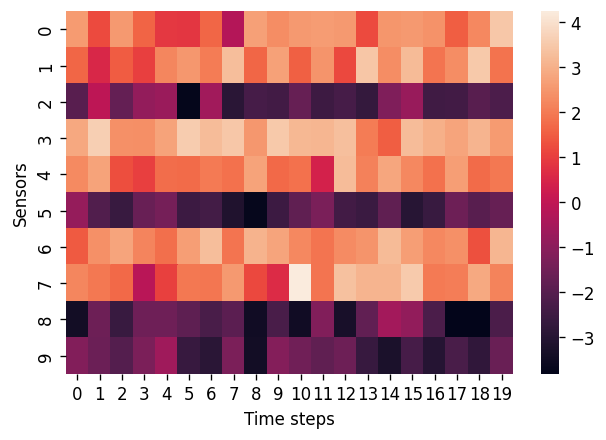

In [ ]:
plt.figure(dpi=120)
ax = sns.heatmap(lweights.T*1000)
plt.xlabel('Time steps')
plt.ylabel('Sensors')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


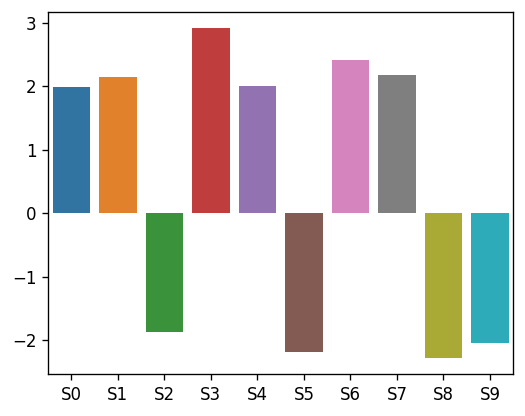

In [ ]:
sensors = ['S'+str(i) for i in range(10)]
plt.figure(num=None, figsize=(5, 4), dpi=120, facecolor='w', edgecolor='k')
sns.barplot(sensors, np.array(weights)*1000)

We will continue with LioNets!

In [ ]:
lionet = LioNets(predictor, decoder, encoder, x_train, double_detector=False)
transparent_model = Ridge(alpha=5, fit_intercept=True, random_state=0)

In [ ]:
weights, res, loc_res = lionet.explain_instance(instance.reshape((20,10)),2000,transparent_model)
lweights = weights.reshape((20,10))
ixweights = weights.reshape((20,10))*instance.reshape((20,10))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


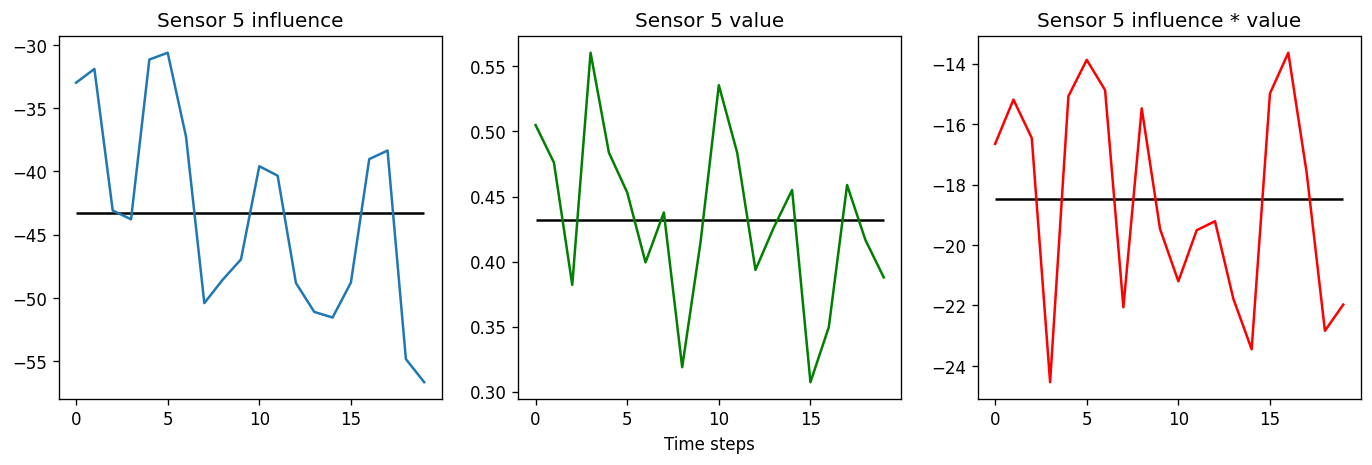

In [ ]:
plt.figure(figsize=(14, 4), dpi=120, facecolor='w', edgecolor='k')
plt.subplot(131)
sns.lineplot(list(range(20)),lweights[:,5]*10000)
plt.hlines(y=(lweights[:,5]*10000).mean(), xmin=0, xmax=19, label='mean')
plt.title(str("Sensor 5 influence"))
plt.subplot(132)
sns.lineplot(list(range(20)),instance[:,5], color='g')
plt.hlines(y=(instance[:,5]).mean(), xmin=0, xmax=19, label='mean')
plt.title(str("Sensor 5 value"))
plt.xlabel('Time steps')
plt.subplot(133)
sns.lineplot(list(range(20)),ixweights[:,5]*10000, color='r')
plt.hlines(y=(ixweights[:,5]*10000).mean(), xmin=0, xmax=19, label='mean')
plt.title(str("Sensor 5 influence * value"))
plt.show()